In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection.search import GridSearchCV
from surprise.model_selection import PredefinedKFold
from surprise import accuracy
from surprise.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
movieData = pd.read_csv('ml-latest-small/ratings.csv')
movieData.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
users = movieData['userId'].values
movies = movieData['movieId'].values
ratings = movieData['rating'].values

In [4]:
#ratings.shape

In [5]:
#movies

### Q1 
Compute the sparsity of the movie rating dataset, where spar-sity is defined by equation 1

In [6]:
print('Sparsity is {:.4f}'.format(len(ratings) / (len(set(movies)) * len(set(users)))))

Sparsity is 0.0170


### Q2
Plot a histogram showing the frequency of the rating values. To be specific, bin the rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R with rating values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram

No handles with labels found to put in legend.


5.0


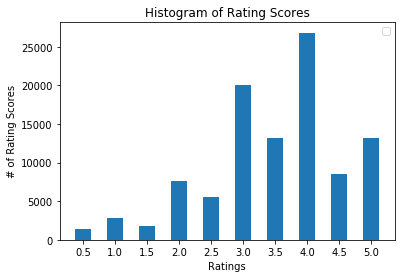

In [7]:
print(max(ratings))
labels = np.unique(ratings)

fig, ax = plt.subplots()
ax.bar(np.arange(len(labels)), np.unique(ratings, return_counts = True)[1], 0.5)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.legend()

plt.title("Histogram of Rating Scores")
plt.xlabel("Ratings")
plt.ylabel("# of Rating Scores")

plt.show()

In [8]:
#np.arange(0,6,0.5)
#np.sum(ratings<=0.5)

In [9]:
# hist=plt.hist(ratings-0.5,bins=np.arange(0,5.5,0.5))
# plt.xlabel('rating',fontsize=15)
# plt.ylabel('counts',fontsize=15)
# plt.title('rating histogram',fontsize=15)

### Q3
Plot the distribution of the number of ratings received among movies. To be specific, the X-axis should be the movie index ordered by decreasing frequency and the Y -axis should be the number of ratings the movie has received. For example, the movie that has the largest number of ratings has index 1; ties can broken in any way. A monotonically decreasing curve instead of a histogram is expected.

In [10]:
len(movieData.query('movieId ==6'))
# It seems the movieID defined in this problem is different than the movieID defined in the dataset. Why would we do this?

102

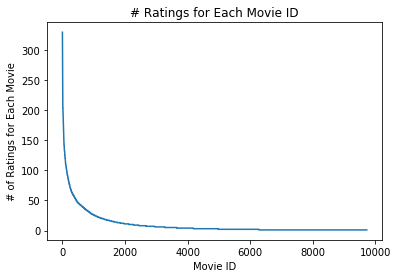

In [11]:
get = np.unique(movies, return_counts = True)

plt.plot(range(len(get[0])), -np.sort(-get[1]))
plt.title('# Ratings for Each Movie ID')
plt.xlabel('Movie ID')
plt.ylabel('# of Ratings for Each Movie')
plt.show()

### Q4
Plot the distribution of ratings among users. To be specific, the X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user have rated. The requirement of the plot is similar to that in Question 3. 

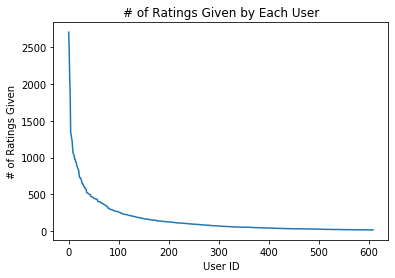

In [12]:
# But the userID here does not correlate to the userID in the orignal dataset, why would we do this?
get = np.unique(users, return_counts = True)

plt.plot(range(len(get[0])), -np.sort(-get[1]))
plt.title('# of Ratings Given by Each User')
plt.xlabel('User ID')
plt.ylabel('# of Ratings Given')
plt.show()

### Question 5: 
Explain the salient features of the distribution found in question 3 and their implications for the recommendation process.

### Sol:
The distribution is extremely skewed. Some movies have a lot more ratings than others, therefore it would be hard to predict the ratings of the movies with less number of reviews. This would also affect the recommendation process since the movies with more exposure would be constantly recommended over the less exposed movies.

### Q6
Compute the variance of the rating values received by each movie. Then, bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram 

No handles with labels found to put in legend.


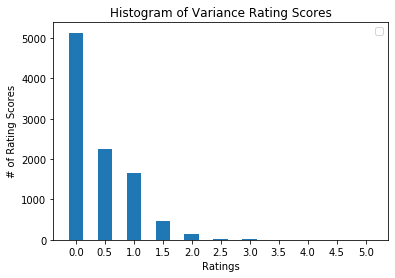

In [13]:
variance = np.var(movieData.pivot_table('rating','userId','movieId'), axis = 0)
variance = round(variance * 2)/2

labels = np.unique(variance)

fig, ax = plt.subplots()
ax.bar(np.arange(len(labels)), np.unique(variance, return_counts = True)[1], 0.5)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.legend()

plt.title("Histogram of Variance Rating Scores")
plt.xlabel("Ratings")
plt.ylabel("# of Rating Scores")

plt.show()

Text(0.5, 1.0, 'movie rating variance histogram')

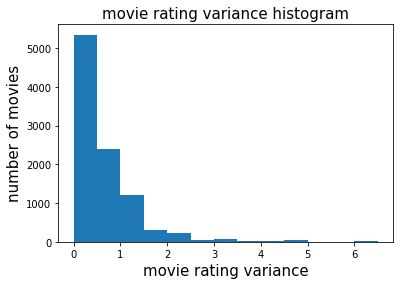

In [14]:
# Just double check the answer
rating_variance=np.nan_to_num(movieData.groupby('movieId').var()['rating'])
plt.hist(rating_variance,bins=np.arange(0,7,0.5))
plt.xlabel('movie rating variance',fontsize=15)
plt.ylabel('number of movies',fontsize=15)
plt.title('movie rating variance histogram',fontsize=15)

### Question 7: 
Write down the formula for lu in terms of Iu and ruk

Pearson-correlation coefficient between users u and v, denoted by Pearson(u,v), captures the similarity between the rating vectors of users u and v. Before stat- ing the formula for computing Pearson(u,v), let’s first introduce some notation:
* Iu : Set of item indices for which ratings have been specified by user u 
* Iv : Set of item indices for which ratings have been specified by user v 
* μu: Mean rating for user u computed using her specified ratings
* ruk: Rating of user u for item k


#### Ans 
$μ_u=(\sum_{k\in I_u}r_{uk})/\sum_{} I_u$

## Question 8

In plain words, explain the meaning of Iu ∩ Iv. Can Iu ∩ Iv = ∅
(Hint: Rating matrix R is sparse). 

### Ans
It means the movies that both users have rated. If it is an empty set, then it means user u and v have no rated movies in common. This is possible as for example, user u watches only comedy genre while user v only watches horror genre.


## Question 9
Can you explain the reason behind mean-centering the raw ratings (rvj − μv) in the prediction function? (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function) 

### Ans
Every user has a different rating standard, some user’s definition of a rating of 3 may be different from other users. Therefore, by mean-centering, this eliminates different definitions of the ratings.So when we do mean centering, the negative rating implies that the user rates the movie less than the average over all the movies he/she has rated. It sort of helps us compare a hard rater and a soft rater on a normalized scale. 


### Q10

Design a k-NN collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).

* Surprise https://surprise.readthedocs.io/en/stable/getting_started.html#tune-algorithm-parameters-with-gridsearchcv

In [15]:
reader = Reader(line_format = 'user item rating timestamp', sep = ',', rating_scale = (0.5, 5), skip_lines=1)
movieDataset = Dataset.load_from_file('ml-latest-small/ratings.csv', reader = reader)

rmse = []
mae = []

for i in range(2,102,2):
    knnModel = KNNWithMeans(k = i, sim_options = {'name': 'pearson', 'user_based': True}, verbose = False)
    cv = cross_validate(knnModel, movieDataset, measures = ['RMSE','MAE'], cv = 10, verbose = False,n_jobs = -2) # use all but 2 CPUs
    rmse.append(np.mean(cv['test_rmse']))
    mae.append(np.mean(cv['test_mae']))
    if i%10==0:
        print('Finished k value: ', i)

Finished k value:  10
Finished k value:  20
Finished k value:  30
Finished k value:  40
Finished k value:  50
Finished k value:  60
Finished k value:  70
Finished k value:  80
Finished k value:  90
Finished k value:  100


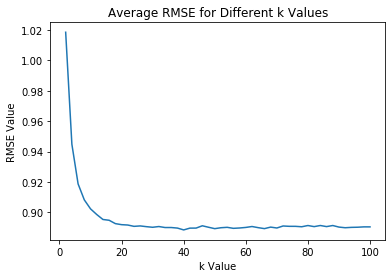

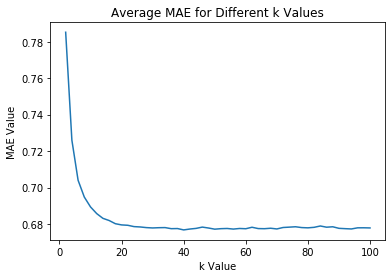

In [16]:
kVals = range(2,102,2)

plt.plot(kVals, rmse)
plt.title('Average RMSE for Different k Values')
plt.xlabel('k Value')
plt.ylabel('RMSE Value')
plt.show()

plt.plot(kVals, mae)
plt.title('Average MAE for Different k Values')
plt.xlabel('k Value')
plt.ylabel('MAE Value')
plt.show()

### Q11
Use the plot from question 10, to find a 'minimum k'. Note: The term 'minimum k' in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then 'minimum k' would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE.

In [17]:
bestK = 0
for k in range(0,len(rmse)-1):
    if(rmse[k+1] < rmse[k]):
        bestK += 2
    else:
        print("Minimum k: ", bestK)
        print("Average RMSE at minimum k: ", rmse[k])
        print("Average MAE at minimum k: ", rmse[k])
        break

Minimum k:  22
Average RMSE at minimum k:  0.8907749706226028
Average MAE at minimum k:  0.8907749706226028


I think the minimum k should be at least 25, 18 seems not completely convergent.

### Q12

Design a k-NN collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

In [18]:
kf = KFold(n_splits = 10)
overallRMSE = [] 

for i in range(2,102,2):
    knnModel = KNNWithMeans(k = i, sim_options = {'name': 'pearson', 'user_based': True}, verbose = False)
    rmse = []
    for trainData, testData in kf.split(movieDataset):
        movieIds = []
        trimTestData = []
        
        for tupleVal in testData:
            movieIds.append(tupleVal[1])
            
        get = np.unique(movieIds, return_counts = True)
        
        for tupleVal in testData:
            if(get[1][np.where(get[0] == tupleVal[1])[0][0]] > 2):
                trimTestData.append(tupleVal)
        
        knnModel.fit(trainData)
        predictions = knnModel.test(trimTestData)
        rmse.append(accuracy.rmse(predictions, verbose=False))
        
    overallRMSE.append(np.mean(rmse))
    if i%10 ==0:
        print('Finished k value: ', i)

Finished k value:  10
Finished k value:  20
Finished k value:  30
Finished k value:  40
Finished k value:  50
Finished k value:  60
Finished k value:  70
Finished k value:  80
Finished k value:  90
Finished k value:  100


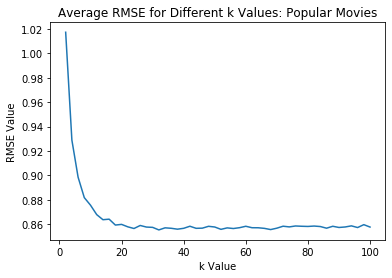

0.8554224495614189


In [19]:
plt.plot(kVals, overallRMSE)
plt.title('Average RMSE for Different k Values: Popular Movies')
plt.xlabel('k Value')
plt.ylabel('RMSE Value')
plt.show()

print(min(overallRMSE))

### Q13

Design a k-NN collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

In [20]:
kf = KFold(n_splits = 10)
overallRMSE = [] 

for i in range(2,102,2):
    knnModel = KNNWithMeans(k = i, sim_options = {'name': 'pearson', 'user_based': True}, verbose = False)
    rmse = []
    for trainData, testData in kf.split(movieDataset):
        movieIds = []
        trimTestData = []
        
        for tupleVal in testData:
            movieIds.append(tupleVal[1])
            
        get = np.unique(movieIds, return_counts = True)
        
        for tupleVal in testData:
            if(get[1][np.where(get[0] == tupleVal[1])[0][0]] <= 2):
                trimTestData.append(tupleVal)
        
        knnModel.fit(trainData)
        predictions = knnModel.test(trimTestData)
        rmse.append(accuracy.rmse(predictions, verbose=False))
        
    overallRMSE.append(np.mean(rmse))
    if i%10 ==0:
        print('Finished k value: ', i)

Finished k value:  10
Finished k value:  20
Finished k value:  30
Finished k value:  40
Finished k value:  50
Finished k value:  60
Finished k value:  70
Finished k value:  80
Finished k value:  90
Finished k value:  100


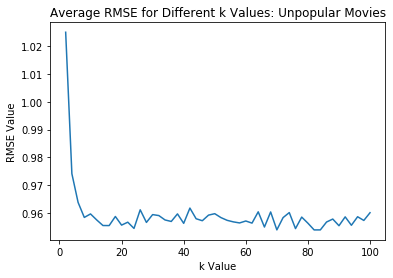

0.9538516800588784


In [21]:
plt.plot(kVals, overallRMSE)
plt.title('Average RMSE for Different k Values: Unpopular Movies')
plt.xlabel('k Value')
plt.ylabel('RMSE Value')
plt.show()

print(min(overallRMSE))

### Q14
Design a k-NN collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k(X-axis). Also, report the minimum average RMSE.

In [22]:
kf = KFold(n_splits = 10)
overallRMSE = [] 

for i in range(2,102,2):
    knnModel = KNNWithMeans(k = i, sim_options = {'name': 'pearson', 'user_based': True}, verbose = False)
    rmse = []
    for trainData, testData in kf.split(movieDataset):
        movieIds = []
        trimTestData = []
        variances = []
        
        for tupleVal in testData:
            movieIds.append(tupleVal[1])
            
        get = np.unique(movieIds, return_counts = True)
        
        for id in movieIds:
            getRatings = []
            for tupleVal in testData:
                if(tupleVal[1] == id):
                    getRatings.append(tupleVal[2])
            variances.append(np.var(getRatings))
        
        for tupleVal in testData:
            if(get[1][np.where(get[0] == tupleVal[1])[0][0]] >= 5 and variances[np.where(get[0] == tupleVal[1])[0][0]] >= 2):
                trimTestData.append(tupleVal)
        
        knnModel.fit(trainData)
        predictions = knnModel.test(trimTestData)
        rmse.append(accuracy.rmse(predictions, verbose=False))
        
    overallRMSE.append(np.mean(rmse))
    if i%10 ==0:
        print('Finished k value: ', i)

Finished k value:  10
Finished k value:  20
Finished k value:  30
Finished k value:  40
Finished k value:  50
Finished k value:  60
Finished k value:  70
Finished k value:  80
Finished k value:  90
Finished k value:  100


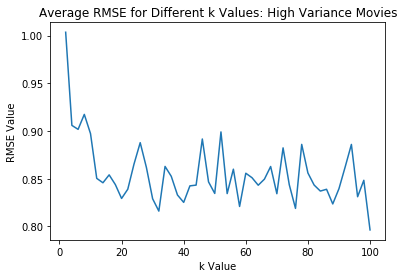

0.7963262589468261


In [23]:
plt.plot(kVals, overallRMSE)
plt.title('Average RMSE for Different k Values: High Variance Movies')
plt.xlabel('k Value')
plt.ylabel('RMSE Value')
plt.show()

print(min(overallRMSE))

### Q15

Plot the ROC curves for the k-NN collaborative filter designed in question 10 for threshold values [2:5; 3; 3:5; 4]. For the ROC plotting use the k found in question 11. For each of the plots, also report the area under the curve (AUC) value.

For the ROC plotting, split the dataset into 90% for training and 10% for testing. For solving question 15 the functions described in the documentation below might be useful.

In [24]:
ratingThresholds = [2.5,3,3.5,4]

def plot_roc_curve(model,mds):
    ratingThresholds = [2.5,3,3.5,4]
    fprs = []
    tprs = []
    aucs = []

    #bestK = 30
    #knnModel = KNNWithMeans(k = bestK, sim_options = {'name': 'pearson', 'user_based': True}, verbose = False)
    trainData, testData = train_test_split(mds)
    model.fit(trainData)
    predictions = model.test(testData)

    for threshold in ratingThresholds:
        binaryEstimate = []
        estimate = []

        for i in range(len(predictions)):
            estimate.append(predictions[i].est)
            if testData[i][2] >= threshold:
                binaryEstimate.append(1)
            else:
                binaryEstimate.append(0)

        fpr, tpr, _ = roc_curve(binaryEstimate, estimate)
        auc = roc_auc_score(binaryEstimate, estimate)

        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc)

        print("finished for rating threshold: ", threshold)

    return fprs,tprs,aucs

finished for rating threshold:  2.5
finished for rating threshold:  3
finished for rating threshold:  3.5
finished for rating threshold:  4


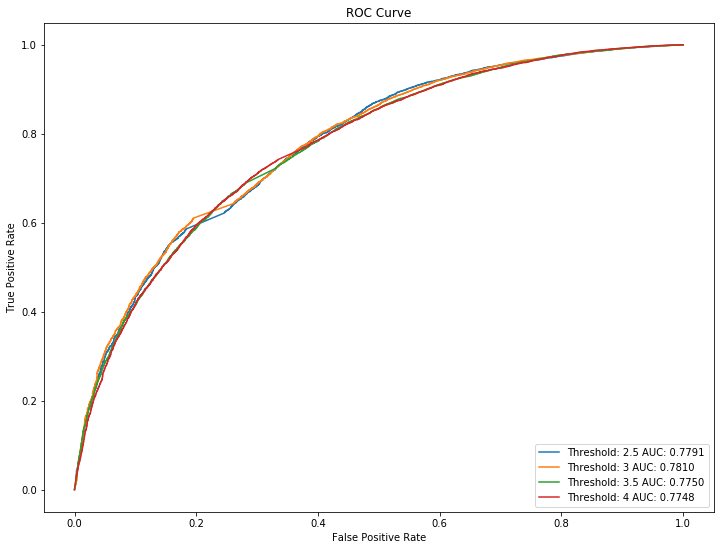

In [25]:

knnModel = KNNWithMeans(k = bestK, sim_options = {'name': 'pearson', 'user_based': True}, verbose = False)
fprs,tprs,aucs = plot_roc_curve(knnModel,movieDataset)


plt.figure(figsize=(12,9))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], label = 'Threshold: {:} AUC: {:.4f}'.format(ratingThresholds[i], aucs[i]) )
plt.legend(loc="lower right")
plt.show()

### Question 16: 
Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.

It's not convex, because the Hessian matrix for the equation is not positive definite (think about (1-xy)^2). However, if we fix U, the process of solving for V is a least-square problem. Same thing for solving for U if we fix V. If we fix U, the problem becomes

$$\underset{V}{minimize}\sum_{i=1}^m\sum_{j=1}^nW_{ij}(r_{ij}-(UV^T)_{ij})^2$$

### Question 17: 
Design a NNMF-based collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it's performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

In [26]:
from sklearn.model_selection import KFold
import os

def define_folds(mds,trim=None):
    popular_movies = mds.groupby('movieId').filter(lambda x: x['rating'].count()>2)['movieId'].unique()
    unpopular_movies = mds.groupby('movieId').filter(lambda x: x['rating'].count()<=2)['movieId'].unique()
    high_var_movies=mds.groupby('movieId').filter(lambda x: (x['rating'].count()>=5) 
                                                      & (x['rating'].var(ddof=0)>=2))['movieId'].unique()
    if not trim: trim='no_trim' 
    if not os.path.isdir(trim): os.makedirs(trim) 
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    folds_files=[]
    for i,(train_index, test_index) in enumerate(kf.split(mds)):
        X_train, X_test = mds.iloc[train_index], mds.iloc[test_index]
        if trim=='popular': X_test=X_test[X_test['movieId'].isin(popular_movies)]
        elif trim=='unpopular': X_test=X_test[X_test['movieId'].isin(unpopular_movies)]
        elif trim=='high_var': X_test=X_test[X_test['movieId'].isin(high_var_movies)]
        train_file,test_file=trim+'/trainset_{:}.csv'.format(i),trim+'/testset_{:}.csv'.format(i)
        X_train.to_csv(train_file,header=False,index=False)
        X_test.to_csv(test_file,header=False,index=False)
        folds_files.append((train_file,test_file))
    return folds_files

def algo_cv(model,mds,k_list,trim=None,**kwargs):
    reader = Reader(line_format='user item rating timestamp', sep=',',rating_scale=(0.5, 5))
    folds_files=define_folds(mds,trim)
    data = Dataset.load_from_folds(folds_files, reader)
    pkf = PredefinedKFold()
    mean_RMSE = []
    mean_MAE =[]
    for k in k_list:
        #print('k (number of neighbors) = {}'.format(i))
        #algo = model(k, random_state=42, shuffle=True, **kwargs)
        if k% 10==0:
            print('k (number of neighbors) = {}'.format(k))
        algo = model(k, random_state=42, **kwargs)
        ret = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=pkf, verbose=False, n_jobs=-2)
        mean_RMSE.append(np.mean(ret['test_rmse']))
        mean_MAE.append(np.mean(ret['test_mae'])) 

    print('min k rmse: ', np.argmin(mean_RMSE))
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,3))
    ax1.plot(k_list,mean_RMSE,label='mean rmse')
    ax1.set_xlabel('number of neighbors k')
    ax1.legend()
    ax2.plot(k_list,mean_MAE,label='mean mae')
    ax2.set_xlabel('number of neighbors k')
    ax2.legend()
    if trim:
        plt.suptitle('trimmed testset on '+trim+', minimum average RMSE: {:.4f}'.format(np.min(mean_RMSE)))
    else:
        plt.suptitle('No trim on testset on, minimum average RMSE: {:.4f}'.format(np.min(mean_RMSE)))
    return mean_RMSE, mean_MAE    

k (number of neighbors) = 10
k (number of neighbors) = 20
k (number of neighbors) = 30
k (number of neighbors) = 40
min k rmse:  8
Q18, min rmse is 0.9099 at k=18 latent factors, min mae is 0.6929 at k=18 latent factors. 
According to readme file there are 18 movie genres
Wall time: 10min 52s


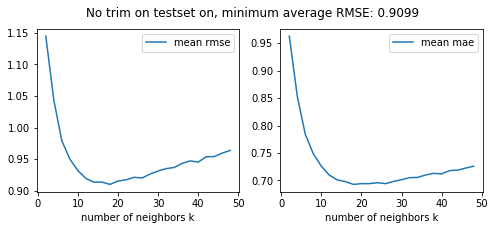

In [27]:
%%time
from surprise.prediction_algorithms.matrix_factorization import NMF
model=NMF #only takes int, not np.int
k_list=list(range(2,50,2))
rmse_NMF,mae_NMF=algo_cv(model,movieData,k_list,trim=None)
print('Q18, min rmse is {:.4f} at k={:} latent factors, min mae is {:.4f} at k={:} latent factors.'.format(
    np.min(rmse_NMF),k_list[np.argmin(rmse_NMF)],np.min(mae_NMF),k_list[np.argmin(mae_NMF)]),
      '\nAccording to readme file there are 18 movie genres')

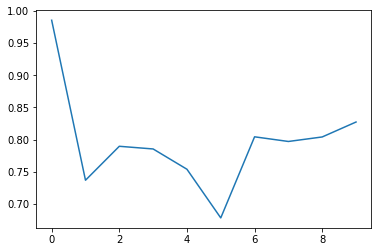

In [28]:
plt.plot(rmse)

### Question 18: 
Use the plot from question 17, to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

### Sol:
min rmse is 0.9144 at k=16 latent factors, min mae is 0.6941 at k=24 latent factors. 
According to readme file there are 18 movie genres

### Q19
Design a NNMF collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

k (number of neighbors) = 10
k (number of neighbors) = 20
k (number of neighbors) = 30
k (number of neighbors) = 40
min k rmse:  8
min rmse is 0.8891 at k=18 latent factors, min mae is 0.6782 at k=18 latent factors.
Wall time: 10min 50s


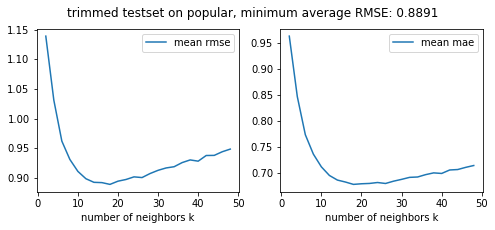

In [29]:
%%time
# the output k in this code is incorrect
from surprise.prediction_algorithms.matrix_factorization import NMF
model=NMF #only takes int, not np.int
k_list=list(range(2,50,2))
rmse_pop,mae_pop=algo_cv(model,movieData,k_list,trim='popular')

print('min rmse is {:.4f} at k={:} latent factors, min mae is {:.4f} at k={:} latent factors.'.format(
    np.min(rmse_pop),k_list[np.argmin(rmse_pop)],np.min(mae_pop),k_list[np.argmin(mae_pop)]))

### Q20
Design a NNMF collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

k (number of neighbors) = 10
k (number of neighbors) = 20
k (number of neighbors) = 30
k (number of neighbors) = 40
min k rmse:  22
min rmse is 1.1748 at k=46 latent factors, min mae is 0.9079 at k=48 latent factors.
Wall time: 10min 16s


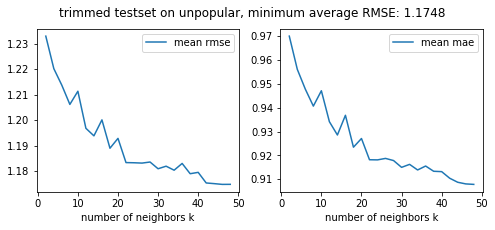

In [30]:
%%time
# the output k in this code is incorrect
from surprise.prediction_algorithms.matrix_factorization import NMF
model=NMF #only takes int, not np.int
k_list=list(range(2,50,2))
rmse_pop,mae_pop=algo_cv(model,movieData,k_list,trim='unpopular')

print('min rmse is {:.4f} at k={:} latent factors, min mae is {:.4f} at k={:} latent factors.'.format(
    np.min(rmse_pop),k_list[np.argmin(rmse_pop)],np.min(mae_pop),k_list[np.argmin(mae_pop)]))

### Q21
Design a NNMF collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

k (number of neighbors) = 10
k (number of neighbors) = 20
k (number of neighbors) = 30
k (number of neighbors) = 40
min k rmse:  19
min rmse is 1.5757 at k=40 latent factors, min mae is 1.2634 at k=40 latent factors.
Wall time: 10min 14s


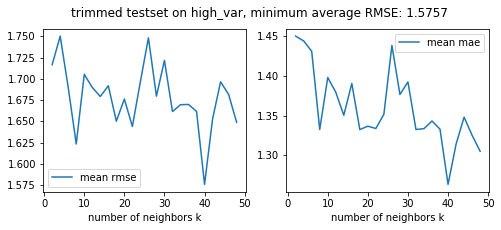

In [31]:
%%time
# the output k in this code is incorrect
from surprise.prediction_algorithms.matrix_factorization import NMF
model=NMF #only takes int, not np.int
k_list=list(range(2,50,2))
rmse_pop,mae_pop=algo_cv(model,movieData,k_list,trim='high_var')

print('min rmse is {:.4f} at k={:} latent factors, min mae is {:.4f} at k={:} latent factors.'.format(
    np.min(rmse_pop),k_list[np.argmin(rmse_pop)],np.min(mae_pop),k_list[np.argmin(mae_pop)]))

### Question 22: 
Plot the ROC curves for the NNMF-based collaborative filter
designed in question 17 for threshold values [2:5; 3; 3:5; 4]. For the ROC plot-
ting use the optimal number of latent factors found in question 18. For each of
the plots, also report the area under the curve (AUC) value.

In [32]:
# the output k in this code is incorrect
from surprise.prediction_algorithms.matrix_factorization import NMF
model=NMF(18) #only takes int, not np.int
fprs,tprs,aucs = plot_roc_curve(model,movieDataset)

finished for rating threshold:  2.5
finished for rating threshold:  3
finished for rating threshold:  3.5
finished for rating threshold:  4


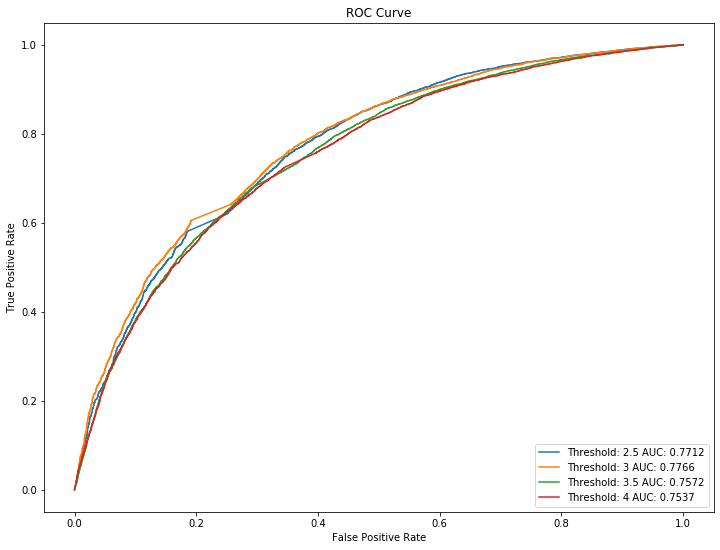

In [33]:
plt.figure(figsize=(12,9))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], label = 'Threshold: {:} AUC: {:.4f}'.format(ratingThresholds[i], aucs[i]) )
plt.legend(loc="lower right")
plt.show()

### Question 23:
Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?

In [34]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(movieData[['userId', 'movieId', 'rating']], reader).build_full_trainset()
model=NMF(20)
model.fit(data)
item_factor=model.qi
movie_orders=np.argsort(item_factor,axis=0)
top_movies=pd.DataFrame(movie_orders[-1:-11:-1 , :])
movies=pd.read_csv('ml-latest-small/movies.csv')
genres=top_movies.applymap(lambda x: movies.iloc[x]['genres'])

In [35]:
genres

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Drama,Comedy,Adventure|Animation|Children|Comedy,Drama,Action|Horror|Sci-Fi|Thriller,Adventure|Comedy|Fantasy,Action|Comedy|Sci-Fi|IMAX,Drama|Musical|Romance,Drama|Thriller,Crime|Drama,Film-Noir|Thriller,Drama,Drama,Drama,Crime|Horror|Thriller,Comedy,Drama|Romance,Comedy|Crime|Thriller,Comedy|Horror|Sci-Fi,Drama|Mystery|Thriller
1,Comedy|Romance,Documentary,Horror|Mystery|Sci-Fi,Action|Adventure|Drama,Children|Comedy,Horror|Sci-Fi,Action|Comedy|Drama|Thriller,Action|Crime|Horror,Adventure|Children,Adventure|Drama|Western,Drama,Comedy|Drama|Romance,Action|Drama|Thriller,Comedy|Horror|Thriller,Drama,Drama,Comedy|Drama|Romance,Action|Comedy|Fantasy|Horror,Comedy,Horror|Sci-Fi
2,Comedy|Drama|War,Action|Horror|Sci-Fi,Comedy,Action|Adventure|Drama|Thriller,Crime|Fantasy|Horror,Film-Noir|Thriller,Action|Drama|Thriller,Drama,Drama|Film-Noir,Drama|Western,Crime|Drama,Drama|Horror|Mystery|Romance|Thriller,Horror,Comedy|Romance,Crime|Thriller,Comedy,Horror,Comedy|Drama|Musical,Drama,Documentary
3,Horror|Thriller,Adventure|Drama|Sci-Fi,Horror,Drama,Comedy|Drama,Comedy|Crime,Comedy,Drama,Comedy,Comedy,Action|Comedy,Drama,Action|Crime|Drama|Thriller,Action|Adventure|Fantasy,Drama|Romance,Drama,Horror|Thriller,Comedy|Romance,Drama,Drama|Romance
4,Comedy|Drama|Romance,Comedy|Drama|Romance,Action|Adventure|Sci-Fi,Comedy,Comedy,Adventure|Drama|War,Drama|Romance|War,Comedy|Drama|Romance,Drama|Thriller,Comedy,Comedy|Drama,Comedy|Romance,Drama|Fantasy|Musical|Romance,Drama,Animation|Children,Drama|Fantasy|Romance,Horror|Sci-Fi|Thriller,Drama|Fantasy|Horror|Romance,Drama,Drama
5,Drama|Horror|Mystery|Thriller,Adventure|Animation|Fantasy|IMAX,Documentary,Comedy,Drama|Romance,Action|Comedy|Crime|Drama,Comedy,Adventure|Drama|Sci-Fi,Comedy|Crime,Crime|Drama|Thriller,Horror|Sci-Fi,Comedy|Drama|Romance,Drama|Fantasy|Romance,Crime|Drama|Musical,Comedy,Children|Comedy,Comedy|Musical|Romance,Crime|Thriller,Horror,Children|Comedy
6,Comedy|Drama,Drama,Action|Crime|Horror,Comedy|Drama|Fantasy|Romance,Horror|Sci-Fi,Comedy|Drama|Romance,Sci-Fi,Adventure|Western,Comedy|Drama,Action|Sci-Fi|Thriller,Documentary|Musical,Action|Crime|Thriller,Drama|Musical,Comedy|Romance,Comedy,Comedy|Drama,Horror,Drama,Mystery|Sci-Fi|Thriller,Comedy|Drama|Romance
7,Comedy|Drama,Adventure|Children,Drama,Comedy|Romance,Crime|Drama,Comedy|Crime|Drama,Comedy,Horror|Thriller,Comedy,Adventure|Comedy|Fantasy,Comedy,Drama|Musical,Comedy,Drama|Thriller,Drama,Crime|Drama,Drama|Thriller,Children|Drama,Fantasy|Mystery|Thriller,Comedy|Romance
8,Drama,Crime|Drama|Thriller,Action|Crime,Drama,Drama|War,Comedy,Comedy|Musical|Romance,Crime|Thriller,Action|Crime|Romance|Thriller,Comedy|Romance,Action|Adventure|Sci-Fi|IMAX,Crime|Drama|Thriller,Documentary,Drama,Comedy|Sci-Fi,Comedy,Adventure|Drama|Romance,Drama|Mystery|Romance|Thriller,Comedy,Drama
9,Comedy,Drama|Mystery,Comedy|Romance,Horror|Sci-Fi|Thriller,Action|Crime|Drama,Drama|Horror|Thriller,Adventure|Drama,Crime|Drama,Action|Adventure|Drama|War,Drama,Comedy|Drama|Romance,Comedy|Drama,Horror|Thriller,Action|Adventure|Fantasy|Sci-Fi,Adventure|Animation|Children|Drama|Sci-Fi,Comedy|Drama|Romance,Drama|Film-Noir|Mystery,Drama|Musical|Romance,Comedy,Horror


For each colume top 10 movies belong to a small collection of genres. For instance column 0,1 mainly has comedy and drama movies and column 4 mainly contains thriller and drama. The latent factors are related to a certain range of genres, and each movie can be thought of as a weighted combination of different genres.

### Question 24: 
Design a MF with bias collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it's performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

k (number of neighbors) = 10
k (number of neighbors) = 20
k (number of neighbors) = 30
k (number of neighbors) = 40
min k rmse:  11
min rmse is 0.8705 at k=24 latent factors, min mae is 0.6676 at k=24 latent factors.
Wall time: 8min 51s


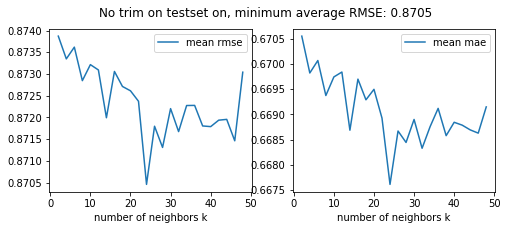

In [36]:
%%time
from surprise.prediction_algorithms.matrix_factorization import SVD
model=SVD #only takes int, not np.int
k_list=list(range(2,50,2))
rmse_svd,mae_svd=algo_cv(model,movieData,k_list,trim=None)

print('min rmse is {:.4f} at k={:} latent factors, min mae is {:.4f} at k={:} latent factors.'.format(
    np.min(rmse_svd),k_list[np.argmin(rmse_svd)],np.min(mae_svd),k_list[np.argmin(mae_svd)]))

### Question 25: 
Use the plot from question 24, to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE.


### Sol:
min rmse is 0.8705 at k=24 latent factors, min mae is 0.6676 at k=24 latent factors.
Wall time: 7min 23s

### Question 26: 
Design a MF with bias collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

k (number of neighbors) = 10
k (number of neighbors) = 20
k (number of neighbors) = 30
k (number of neighbors) = 40
min k rmse:  11
min rmse is 0.8650 at k=24 latent factors, min mae is 0.6632 at k=24 latent factors.
Wall time: 8min 49s


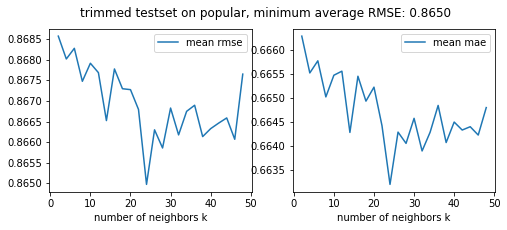

In [37]:
%%time
from surprise.prediction_algorithms.matrix_factorization import SVD
model=SVD #only takes int, not np.int
k_list=list(range(2,50,2))
rmse_svd,mae_svd=algo_cv(model,movieData,k_list,trim='popular')

print('min rmse is {:.4f} at k={:} latent factors, min mae is {:.4f} at k={:} latent factors.'.format(
    np.min(rmse_svd),k_list[np.argmin(rmse_svd)],np.min(mae_svd),k_list[np.argmin(mae_svd)]))

### Question 27: 
Design a MF with bias collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

k (number of neighbors) = 10
k (number of neighbors) = 20
k (number of neighbors) = 30
k (number of neighbors) = 40
min k rmse:  22
min rmse is 0.9520 at k=46 latent factors, min mae is 0.7363 at k=44 latent factors.
Wall time: 8min 15s


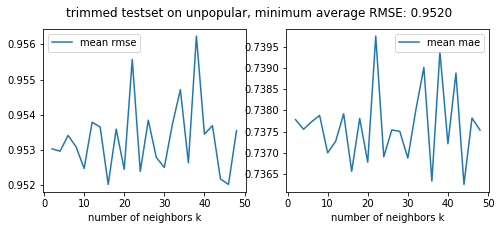

In [38]:
%%time
from surprise.prediction_algorithms.matrix_factorization import SVD
model=SVD #only takes int, not np.int
k_list=list(range(2,50,2))
rmse_svd,mae_svd=algo_cv(model,movieData,k_list,trim='unpopular')

print('min rmse is {:.4f} at k={:} latent factors, min mae is {:.4f} at k={:} latent factors.'.format(
    np.min(rmse_svd),k_list[np.argmin(rmse_svd)],np.min(mae_svd),k_list[np.argmin(mae_svd)]))

### Question 28: 
Design a MF with bias collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE

k (number of neighbors) = 10
k (number of neighbors) = 20
k (number of neighbors) = 30
k (number of neighbors) = 40
min k rmse:  23
min rmse is 1.4386 at k=48 latent factors, min mae is 1.1693 at k=48 latent factors.
Wall time: 8min 12s


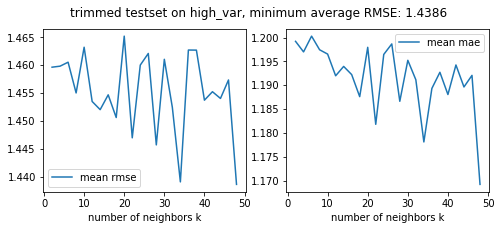

In [39]:
%%time
from surprise.prediction_algorithms.matrix_factorization import SVD
model=SVD #only takes int, not np.int
k_list=list(range(2,50,2))
rmse_svd,mae_svd=algo_cv(model,movieData,k_list,trim='high_var')

print('min rmse is {:.4f} at k={:} latent factors, min mae is {:.4f} at k={:} latent factors.'.format(
    np.min(rmse_svd),k_list[np.argmin(rmse_svd)],np.min(mae_svd),k_list[np.argmin(mae_svd)]))

### Q29
Plot the ROC curves for the MF with bias (SVD) collaborative filter

In [40]:
from surprise.prediction_algorithms.matrix_factorization import SVD
reader = Reader(line_format = 'user item rating timestamp', sep = ',', rating_scale = (0.5, 5), skip_lines=1)
movieDataset = Dataset.load_from_file('ml-latest-small/ratings.csv', reader = reader)

model = SVD(24)
fprs,tprs,aucs = plot_roc_curve(model,movieDataset)

finished for rating threshold:  2.5
finished for rating threshold:  3
finished for rating threshold:  3.5
finished for rating threshold:  4


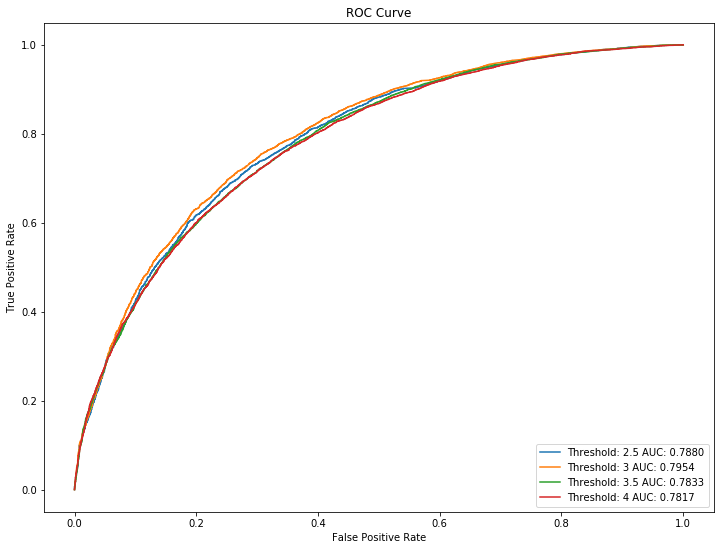

In [41]:
plt.figure(figsize=(12,9))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], label = 'Threshold: {:} AUC: {:.4f}'.format(ratingThresholds[i], aucs[i]) )
plt.legend(loc="lower right")
plt.show()